# A/B Test for Gym Members

## Goal
The goal of this project is to compare the difference between `Group A` (people who were given the fitness test with a personal trainer) and `Group B` (people who were not given the fitness test) at each state of the process:

* Percent of visitors who apply.
* Percent of applicants who purchase a membership.
* Percent of all visitors who purchase a membership.

## Dataset
* `visits` contains information about potential gym customers who have visited the gym.
* `fitness_tests` contains information about potential customers in "Group A", who were given a fitness test.
* `applications` contains information about any potential customers (both "Group A" and "Group B") who filled out an application. Not everyone in visits will have filled out an application.
* `purchases` contains information about customers who purchased a membership.

> Notes: This project is based on a capstone project in the Data Analyst course on Codecademy.

In [1]:
from pathlib import Path
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency

In [2]:
# Define file path
curr_dir = Path(__file__).parent if "__file__" in locals() else Path.cwd()
database_path = curr_dir / 'database.db'
output_dir = curr_dir / 'output'

# create the output directory
output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# create a connection to the database
conn = sqlite3.connect(database_path)

In [4]:
# Examine visits
visits = pd.read_sql_query('''
SELECT *
FROM visits
WHERE visits.visit_date >= "7-1-17"
LIMIT 5
''', conn)
visits

,index,first_name,last_name,email,gender,visit_date
0,1000,Kim,Walter,KimWalter58@gmail.com,female,7-1-17
1,1001,Tom,Webster,TW3857@gmail.com,male,7-1-17
2,1002,Edward,Bowen,Edward.Bowen@gmail.com,male,7-1-17
3,1003,Marcus,Bauer,Marcus.Bauer@gmail.com,male,7-1-17
4,1004,Roberta,Best,RB6305@hotmail.com,female,7-1-17


In [5]:
# Examine fitness_tests
fitness_tests = pd.read_sql_query('''
SELECT *
FROM fitness_tests
LIMIT 5
''', conn)
fitness_tests

,index,first_name,last_name,email,gender,fitness_test_date
0,0,Kim,Walter,KimWalter58@gmail.com,female,2017-07-03
1,1,Tom,Webster,TW3857@gmail.com,male,2017-07-02
2,2,Marcus,Bauer,Marcus.Bauer@gmail.com,male,2017-07-01
3,3,Roberta,Best,RB6305@hotmail.com,female,2017-07-02
4,4,Carrie,Francis,CF1896@hotmail.com,female,2017-07-05


In [6]:
# Examine applications
applications = pd.read_sql_query('''
SELECT *
FROM applications
LIMIT 5
''', conn)
applications

,index,first_name,last_name,email,gender,application_date
0,0,Roy,Abbott,RoyAbbott32@gmail.com,male,2017-08-12
1,1,Agnes,Acevedo,AgnesAcevedo1@gmail.com,female,2017-09-29
2,2,Roberta,Acevedo,RA8063@gmail.com,female,2017-09-15
3,3,Darren,Acosta,DAcosta1996@hotmail.com,male,2017-07-26
4,4,Vernon,Acosta,VAcosta1975@gmail.com,male,2017-07-14


In [7]:
# Examine purchases
purchases = pd.read_sql_query('''
SELECT * 
FROM purchases
LIMIT 5
''', conn)
purchases

,index,first_name,last_name,email,gender,purchase_date
0,0,Roy,Abbott,RoyAbbott32@gmail.com,male,2017-08-18
1,1,Roberta,Acevedo,RA8063@gmail.com,female,2017-09-16
2,2,Vernon,Acosta,VAcosta1975@gmail.com,male,2017-07-20
3,3,Darren,Acosta,DAcosta1996@hotmail.com,male,2017-07-27
4,4,Dawn,Adkins,Dawn.Adkins@gmail.com,female,2017-08-24


## Investigate the A and B groups

Create a df from dataset that contain:

- `visits.first_name`
- `visits.last_name`
- `visits.gender`
- `visits.email`
- `visits.visit_date`
- `fitness_tests.fitness_test_date`
- `applications.application_date`
- `purchases.purchase_date`
> Note: A/B test only occured after `7-1-17`. 

In [8]:
# Joining tables and querying the data
query = '''
SELECT 
    visits.first_name,
    visits.last_name,
    visits.gender,
    visits.email,
    visits.visit_date,
    fitness_tests.fitness_test_date,
    applications.application_date,
    purchases.purchase_date
FROM visits
LEFT JOIN fitness_tests
    ON visits.first_name = fitness_tests.first_name
    AND visits.last_name = fitness_tests.last_name
    AND visits.email = fitness_tests.email
LEFT JOIN applications
    ON visits.first_name = applications.first_name
    AND visits.last_name = applications.last_name
    AND visits.email = applications.email
LEFT JOIN purchases
    ON visits.first_name = purchases.first_name
    AND visits.last_name = purchases.last_name
    AND visits.email = purchases.email
WHERE visits.visit_date >= "7-1-17"
'''
df = pd.read_sql_query(query, conn)
df

,first_name,last_name,gender,email,visit_date,fitness_test_date,application_date,purchase_date
0,Kim,Walter,female,KimWalter58@gmail.com,7-1-17,2017-07-03,None,None
1,Tom,Webster,male,TW3857@gmail.com,7-1-17,2017-07-02,None,None
2,Edward,Bowen,male,Edward.Bowen@gmail.com,7-1-17,None,2017-07-04,2017-07-04
3,Marcus,Bauer,male,Marcus.Bauer@gmail.com,7-1-17,2017-07-01,2017-07-03,2017-07-05
4,Roberta,Best,female,RB6305@hotmail.com,7-1-17,2017-07-02,None,None
...,...,...,...,...,...,...,...,...
4999,Rachel,Hensley,female,RachelHensley38@gmail.com,9-9-17,None,None,None
5000,Leon,Harmon,male,Leon.Harmon@gmail.com,9-9-17,2017-09-15,None,None
5001,Andy,Pratt,male,AndyPratt27@gmail.com,9-9-17,2017-09-15,None,None
5002,Ruben,Nielsen,male,RubenNielsen93@hotmail.com,9-9-17,None,2017-09-13,None


In [9]:
# add 'ab_test_group' column
df['ab_test_group'] = df.fitness_test_date.apply(lambda x: 'A' if pd.notnull(x) else 'B')
ab_counts = df.groupby('ab_test_group').first_name.count().reset_index()
ab_counts

,ab_test_group,first_name
0,A,2504
1,B,2500


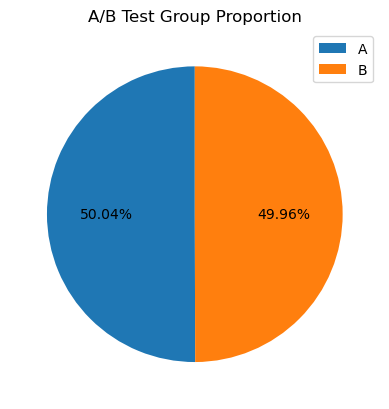

In [10]:
plt.pie(ab_counts.first_name.values, autopct='%.2f%%', startangle=90)
plt.legend(['A','B'])
plt.title('A/B Test Group Proportion')
plt.show()

## Who picks up an application?

In [11]:
# add 'is_application' column to check how many people filling out an application.
df['is_application'] = df.application_date.apply(lambda x: 'Application' if pd.notnull(x) else 'No Application')

# groupby to count people from Group A and Group B.
app_counts = df.groupby(['ab_test_group', 'is_application']).first_name.count().reset_index()

# calculate total and percent of people in each group who complete an application.
app_pivot = app_counts.pivot(columns='is_application', index='ab_test_group', values='first_name').reset_index()
app_pivot['Total'] = app_pivot['Application'] + app_pivot['No Application']
app_pivot['Percent with Application'] = app_pivot['Application'] / app_pivot['Total']
app_pivot

is_application,ab_test_group,Application,No Application,Total,Percent with Application
0,A,250,2254,2504,0.09984
1,B,325,2175,2500,0.13000


In [12]:
# check if statistically significant.
chi2, pval, dof, expected = chi2_contingency([[250,2254],[325,2175]])
pval

0.0009647827600722304

In [13]:
# pval < 0.05 - 'Significant'

## Who purchases a membership?

### Of those who picked up an application, how many purchased a membership?

In [14]:
# add 'is_member' column to check how many people who purchased a membership.
df['is_member'] = df['purchase_date'].apply(lambda x: 'Member' if pd.notnull(x) else 'Not Member')

# add 'just_apps' to check how many people picked up an application.
just_apps = df[df.is_application == 'Application']

# groupby to count how many people picked up an application and purchased a membership
member = just_apps.groupby(['ab_test_group', 'is_member']).first_name.count().reset_index()

# calculate total and percent of people in each group who purchased a membership.
member_pivot = member.pivot(columns='is_member', index='ab_test_group', values='first_name').reset_index()
member_pivot['Total'] = member_pivot['Member'] + member_pivot['Not Member']
member_pivot['Percent Purchase'] = member_pivot['Member'] / member_pivot['Total']
member_pivot

is_member,ab_test_group,Member,Not Member,Total,Percent Purchase
0,A,200,50,250,0.800000
1,B,250,75,325,0.769231


In [15]:
# check if statistically significant.
chi2, pval, dof, expected = chi2_contingency([[200,50],[250,75]])
pval

0.43258646051083327

In [16]:
# pval > 0.05 - 'No Significant'

### Of all visitor, how many purchased a membership?

In [17]:
# groupby to count how many people purchased a membership
final_member = df.groupby(['ab_test_group', 'is_member']).first_name.count().reset_index()

# calculate total and percent of people in each group who purchased a membership.
final_member_pivot = final_member.pivot(columns='is_member', index='ab_test_group', values='first_name').reset_index()
final_member_pivot['Total'] = final_member_pivot['Member'] + final_member_pivot['Not Member']
final_member_pivot['Percent Purchase'] = final_member_pivot['Member'] / final_member_pivot['Total']
final_member_pivot

is_member,ab_test_group,Member,Not Member,Total,Percent Purchase
0,A,200,2304,2504,0.079872
1,B,250,2250,2500,0.100000


In [18]:
# check if statistically significant.
chi2, pval, dof, expected = chi2_contingency([[200,2304],[250,2250]])
pval

0.014724114645783203

In [19]:
# pval < 0.05 - 'Significant'

## Summarize

Create a bar chart to show the difference between Group A (people who were given the fitness test) and 
- Percent of visitors who apply
- Percent of applicants who purchase a membership
- Percent of visitors who purchase a membership

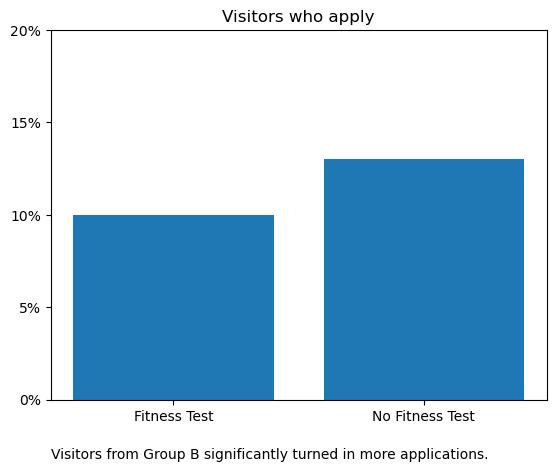

<Figure size 640x480 with 0 Axes>

In [20]:
# Percent of visitors who apply
ax = plt.subplot()
plt.bar(range(len(app_pivot)), app_pivot['Percent with Application'].values)
ax.set_xticks(range(len(app_pivot)))
ax.set_xticklabels(['Fitness Test', 'No Fitness Test'])
ax.set_yticks([0.00, 0.05, 0.10, 0.15, 0.20])
ax.set_yticklabels(['0%', '5%', '10%', '15%', '20%'])
ax.annotate('Visitors from Group B significantly turned in more applications.',
            xy = (0, -0.15),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=10)
plt.title('Visitors who apply')
plt.savefig(output_dir/'percent_visitor_apply.png')
plt.show()
plt.clf()

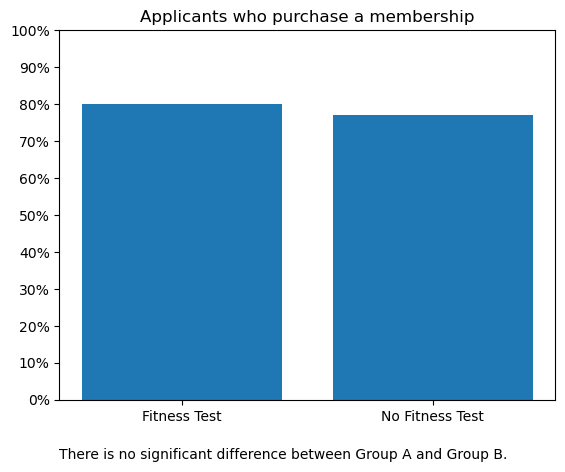

In [21]:
# Percent of applicants who purchase a membership
ax = plt.subplot()
plt.bar(range(len(member_pivot)), member_pivot['Percent Purchase'].values)
ax.set_xticks(range(len(member_pivot)))
ax.set_xticklabels(['Fitness Test', 'No Fitness Test'])
ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
ax.annotate('There is no significant difference between Group A and Group B.',
            xy = (0, -0.15),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=10)
plt.title('Applicants who purchase a membership')
plt.savefig(output_dir/'percent_apply_purchase.png')
plt.show()

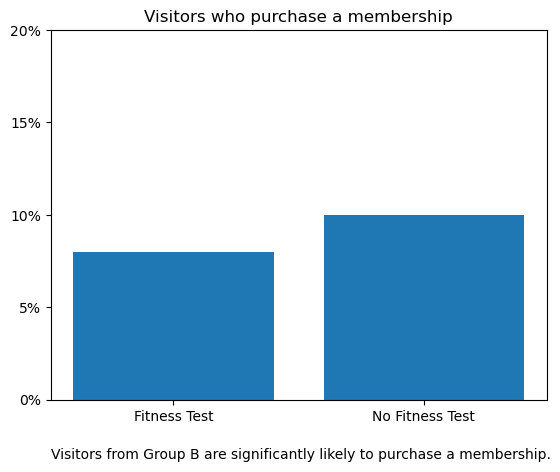

In [22]:
# Percent of visitors who purchase a membership
ax = plt.subplot()
plt.bar(range(len(final_member_pivot)), final_member_pivot['Percent Purchase'].values)
ax.set_xticks(range(len(final_member_pivot)))
ax.set_xticklabels(['Fitness Test', 'No Fitness Test'])
ax.set_yticks([0, 0.05, 0.10, 0.15, 0.20])
ax.set_yticklabels(['0%', '5%', '10%', '15%', '20%'])
ax.annotate('Visitors from Group B are significantly likely to purchase a membership.',
            xy = (0, -0.15),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=10)
plt.title('Visitors who purchase a membership')
plt.savefig(output_dir/'percent_visitors_purchase.png')
plt.show()

In [23]:
# Close the connection
conn.close()